In [82]:
import numpy as np
from matplotlib import pyplot as plt

In [83]:
def correct_dimensions(s, targetlength):
  """checks the dimensionality of some numeric argument s, broadcasts it
      to the specified length if possible.
  Args:
      s: None, scalar or 1D array
      targetlength: expected length of s
  Returns:
      None if s is None, else numpy vector of length targetlength
  """
  if s is not None:
    s = np.array(s)
    if s.ndim == 0:
      s = np.array([s] * targetlength)
    elif s.ndim == 1:
      if not len(s) == targetlength:
        raise ValueError("arg must have length " + str(targetlength))
    else:
        raise ValueError("Invalid argument")
  return s

def mse(prediction,data):
  return np.sqrt(np.mean((prediction - data)**2))

def permute(expanded,amount):
  return np.array(list(expanded)[amount:len(expanded)]+list(expanded)[0:amount])

def identity(x):
  return x

def binarytoplusmin1(input):
  return 1-2*(input)

randMatMeta=np.random.rand(2000,2)
randMatMeta=np.rint(randMatMeta)
# randMatMeta=np.zeros((1000,2))
# print(randMatMeta)
# randMatMeta[:,0]=np.ones((1000,))
randMatMeta=binarytoplusmin1(randMatMeta)
# print(randMatMeta)
def regularizebetween0and1(X):
  range=[min(X.flatten()),max(X.flatten())-min(X.flatten())]
  if range[1]==0:
    ekans=np.zeros(np.shape(X))
    return ekans
  Xnew=np.zeros(np.shape(X))
  # for i in range(0,len(X[0])):
  #   Xnew[:,i]=(X[:,i]-range[0])/range[1]
  Xnew=(X-range[0])/range[1]
  return Xnew

def oneorminus():
  if np.random.random()>.5:
    return -1
  return 1

def oneorzero():
  if np.random.random()>.5:
    return 0
  return 1

def quantize(vector,size):
  randMat=randMatMeta[:size]
  newvector=regularizebetween0and1(vector)
  # print(newvector)
  return np.array([[randMat[i][0] if np.random.random()>value else randMat[i][1] for i in range(0,size)]for value in newvector])

def clip(vector, max):
  return np.clip(vector,-max,max)
  
def cosinesimilarity(vector1,vector2):
  return np.dot(vector1,vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2))


In [84]:
def identity(x):
    return x
class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.
        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (permute(state,1)
                      + input_pattern
                      + output_pattern)
            # preactivation = (np.dot(self.W, state)
            #                  + np.dot(self.W_in, input_pattern)
            #                  + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return clip(preactivation,3)#+np.array([0 if np.random.random()>self.noise else oneorminus() for i in range(0,self.n_reservoir)])

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.
        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states
        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.
        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state
        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

In [85]:
data = np.load('mackey_glass_t17.npy') #  http://minds.jacobs-university.de/mantas/code #link doesn't work, use copy of file on github- bobby
regdata=regularizebetween0and1(data)                                        #https://github.com/cknd/pyESN
print(regdata)

[0.77479487 0.68558728 0.60750875 ... 0.42662685 0.46577059 0.50978415]


harvesting states...
fitting...
training error:
0.456902013776652
test error: 
0.13610324337350185


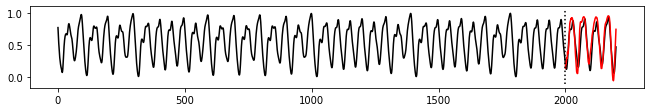

In [95]:
size=1000
esn = ESN(n_inputs = size,
          n_outputs = size,
          n_reservoir = size,
          spectral_radius = 1,
          random_state=42, silent=False)
hdcdata=quantize(data,size)
trainlen = 2000
future = 200
pred_training = esn.fit(np.zeros((trainlen,size)),hdcdata[:trainlen])#binarytoplusmin1(np.rint(np.random.rand(trainlen,size))
prediction = esn.predict(np.zeros((trainlen,size)))#
reconstruction=np.array([cosinesimilarity(prediction[i],randMatMeta[:size,1])for i in range(0,future)])
# print([cosinesimilarity(prediction[i],randMatMeta[:size,0])for i in range(0,future)])
print("test error: \n"+str(np.sqrt(np.mean((reconstruction - regdata[trainlen:trainlen+future])**2))))

plt.figure(figsize=(11,1.5))
plt.plot(range(0,trainlen+future),regdata[0:trainlen+future],'k',label="target system")
plt.plot(range(trainlen,trainlen+future),reconstruction,'r', label="free running ESN")
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')

In [87]:
# print("test error: \n"+str(np.sqrt(np.mean((reconstruction - regdata[trainlen:trainlen+future])**2))))
def ESNacc(data,trainlen,future, size,spectral_radius,random_state, dump):
    esn = ESN(n_inputs = size,
            n_outputs = size,
            n_reservoir = size,
            spectral_radius = spectral_radius,
            random_state=random_state)
    hdcdata=quantize(data,size)
    trainlen = 2000
    future = 200
    esn.fit(np.zeros((trainlen,size)),hdcdata[:trainlen])#binarytoplusmin1(np.rint(np.random.rand(trainlen,size))
    prediction = esn.predict(np.zeros((trainlen,size)))#
    reconstruction=np.array([cosinesimilarity(prediction[i],randMatMeta[:size,1])for i in range(0,future)])
    if dump:
        return [mse(reconstruction,data[trainlen:trainlen+future]),prediction]
    return mse(reconstruction.flatten(),data[trainlen:trainlen+future])

In [88]:
def colorgraph(matrix):
    f, ax = plt.subplots(1,1,figsize=(8,5))
    cax = ax.matshow(matrix, interpolation="nearest")
    f.colorbar(cax)
    f.suptitle("Label Confusion Matrix")
    # ax.set_xticklabels(['']+A)
    # ax.set_yticklabels(['']+K)
    plt.show()

threshold error: 
0.20077556815251502
0
1
2
3
4


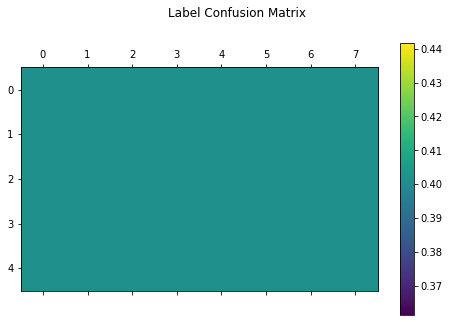

In [94]:
neurons=[800,900,1000,1100,1200]
spectradius=[.5,.75,1,1.25,1.5,1.75,2,2.25,2.5]
def getmap(trainlen,future, data,random, neurons, spectradius):
  mean = np.mean(data[:trainlen])
  meanguess=[ mean for i in range(0,future)]
  thresh=mse(meanguess,data[trainlen:trainlen+future])
  print( "threshold error: \n" + str(thresh))
  map=np.zeros((5,8))
  for i in range(0,5):
    print(i)
    for j in range(0,8):
      map[i,j]=min([thresh*2,ESNacc(data,trainlen,future, neurons[i],spectradius[j],random, False)])
  return map
trainlen=2000
future = 200
random = 48
map=getmap(int(trainlen*trainlen/(trainlen+future)),int(trainlen*future/(trainlen+future)),data,random, neurons,spectradius)#find map from train data
colorgraph(map)
coords=[int(np.floor(np.argmin(map)/len(map[0]))),np.argmin(map)%len(map[0])]
# print(np.argmin(map))
# print(coords)
acc,prediction = ESNacc(data,trainlen,future, neurons[coords[1]],spectradius[coords[0]],random, True)

harvesting states...
fitting...
training error:
0.4575686192003755
test error: 
0.3621493321035899


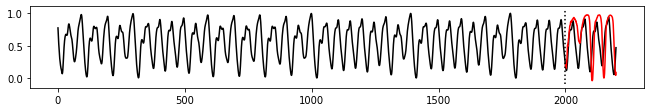

In [102]:
size=1000
esn = ESN(n_inputs = size,
          n_outputs = size,
          n_reservoir = size,
          spectral_radius = 1,
          random_state=42, silent=False,noise=.2)
hdcdata=quantize(data,size)
trainlen = 2000
future = 200
pred_training = esn.fit(np.zeros((trainlen,size)),hdcdata[:trainlen])#binarytoplusmin1(np.rint(np.random.rand(trainlen,size))
prediction = esn.predict(np.zeros((trainlen,size)))#
reconstruction=np.array([cosinesimilarity(prediction[i],randMatMeta[:size,1])for i in range(0,future)])
# print([cosinesimilarity(prediction[i],randMatMeta[:size,0])for i in range(0,future)])
print("test error: \n"+str(np.sqrt(np.mean((reconstruction - regdata[trainlen:trainlen+future])**2))))

plt.figure(figsize=(11,1.5))
plt.plot(range(0,trainlen+future),regdata[0:trainlen+future],'k',label="target system")
plt.plot(range(trainlen,trainlen+future),reconstruction,'r', label="free running ESN")
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')